# Figure 3

In [1]:
import os

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.75, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

## Load computed ToE data

In [4]:
toe_savedir = "../data/20250617/"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc").squeeze()
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

Take percentiles from PI-Control Runs of models

In [7]:
cesm1_regional_trends_filepath = '../data/20250617/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.040001-220012.1900trends.Percentiles.nc'
cesm1_spatial_trends_filepath = '../data/20250617/b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.040001-179912.5x5degSpatialTrends.3_120_years.Percentiles.nc'

Load the trend data.

In [8]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(cesm1_spatial_trends_filepath)
cesm1_pic_spatial_trends_all["percentile"] = [0.025, 0.975]

In [9]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(cesm1_regional_trends_filepath)

#### Observations

Also load trend percentiles for cone plots

In [12]:
gistemp_5x5_spatial_trendpercs_filepath = '../data/20250617/ensembleChunks_0001_0200.trends.movingstartdate.Percentiles.5x5.190001-202012.nc'
gistemp_regional_trendpercs_filepath = '../data/20250617/ensembleChunks_0001_0200.trends.movingstartdate.Percentiles.IPCCRegions.190001-202012.nc'

In [13]:
gistemp_5x5_spatial_trendpercs_all  = xr.open_dataarray(gistemp_5x5_spatial_trendpercs_filepath).drop('startyear').squeeze()
gistemp_regional_trendpercs_all  = xr.open_dataarray(gistemp_regional_trendpercs_filepath)

/glade/derecho/scratch/jonahshaw/tmp/ipykernel_9748/1435539606.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  gistemp_5x5_spatial_trendpercs_all  = xr.open_dataarray(gistemp_5x5_spatial_trendpercs_filepath).drop('startyear').squeeze()


Load start years as well

In [16]:
gistemp_spatial_startyears_filepath = '../data/20250617/ensembleChunks_0001_0200.startyears.5x5.190001-202012.nc'
gistemp_regional_startyears_filepath = '../data/20250617/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc'

In [17]:
gistemp_spatial_startyears = xr.open_dataarray(gistemp_spatial_startyears_filepath)
gistemp_regional_startyears = xr.open_dataarray(gistemp_regional_startyears_filepath)

In [18]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_spatial_startyears = process_startyears(
    gistemp_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_startyears = process_startyears(
    gistemp_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

### Collate data for easy access

In [19]:
obs_spatial_perc_dict = {
    "GISTEMP_5x5":gistemp_5x5_spatial_trendpercs_all,
}
obs_regional_perc_dict = {
    "GISTEMP_5x5":gistemp_regional_trendpercs_all,
}
obs_perc_dict = {
    "spatial":obs_spatial_perc_dict,
    "regional":obs_regional_perc_dict,
}

obs_spatial_startyear_dict = {
    "GISTEMP_5x5": gistemp_spatial_startyears,
}
obs_regional_startyear_dict = {
    "GISTEMP_5x5": gistemp_regional_startyears,
}
obs_startyear_dict = {
    "spatial": obs_spatial_startyear_dict,
    "regional": obs_regional_startyear_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute uncertainty ratio

In [20]:
cesm1_pic_95confspread   = cesm1_pic_regional_trends_all.sel(percentile=0.975) - cesm1_pic_regional_trends_all.sel(percentile=0.025)
gistemp_reg_95confspread = gistemp_regional_trendpercs_all.sel(percentile=0.975) - gistemp_regional_trendpercs_all.sel(percentile=0.025)

gistemp_cesm1_uncratio = gistemp_reg_95confspread / cesm1_pic_95confspread

In [21]:
gistemp_5x5_trends_50perc_reindex = gistemp_regional_trendpercs_all.sel(percentile=0.5).copy()
regional_tte_data = regional_masked_da

mean_tte  = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='mean')
strict_tte = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='strict')

startyear = 1900

reindexed_trends = []
for region_index in gistemp_5x5_trends_50perc_reindex.RegionIndex:

    region_trends = gistemp_5x5_trends_50perc_reindex.sel(RegionIndex=region_index)
    region_mean_tte = mean_tte.sel(RegionIndex=region_index)
    
    region_trends['years_since_emerge'] = startyear + region_trends.duration - 1 - region_mean_tte
    
    reindexed_trends.append(region_trends)    

reindexed_trends_concat = xr.concat(reindexed_trends,dim='RegionIndex')

In [22]:
# Compute delays for all regions.
mean_delay_trends = []

for delay in range(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max())):
    
    delay_mean_value = reindexed_trends_concat.where(reindexed_trends_concat.years_since_emerge==delay).mean()
    
    mean_delay_trends.append(delay_mean_value.values)

delay_range = np.arange(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max()))

delay_da = xr.DataArray(
    data=mean_delay_trends,
    dims=["delay",],
    coords={'delay':delay_range}
)

Text(-0.05, 1.08, 'f.')

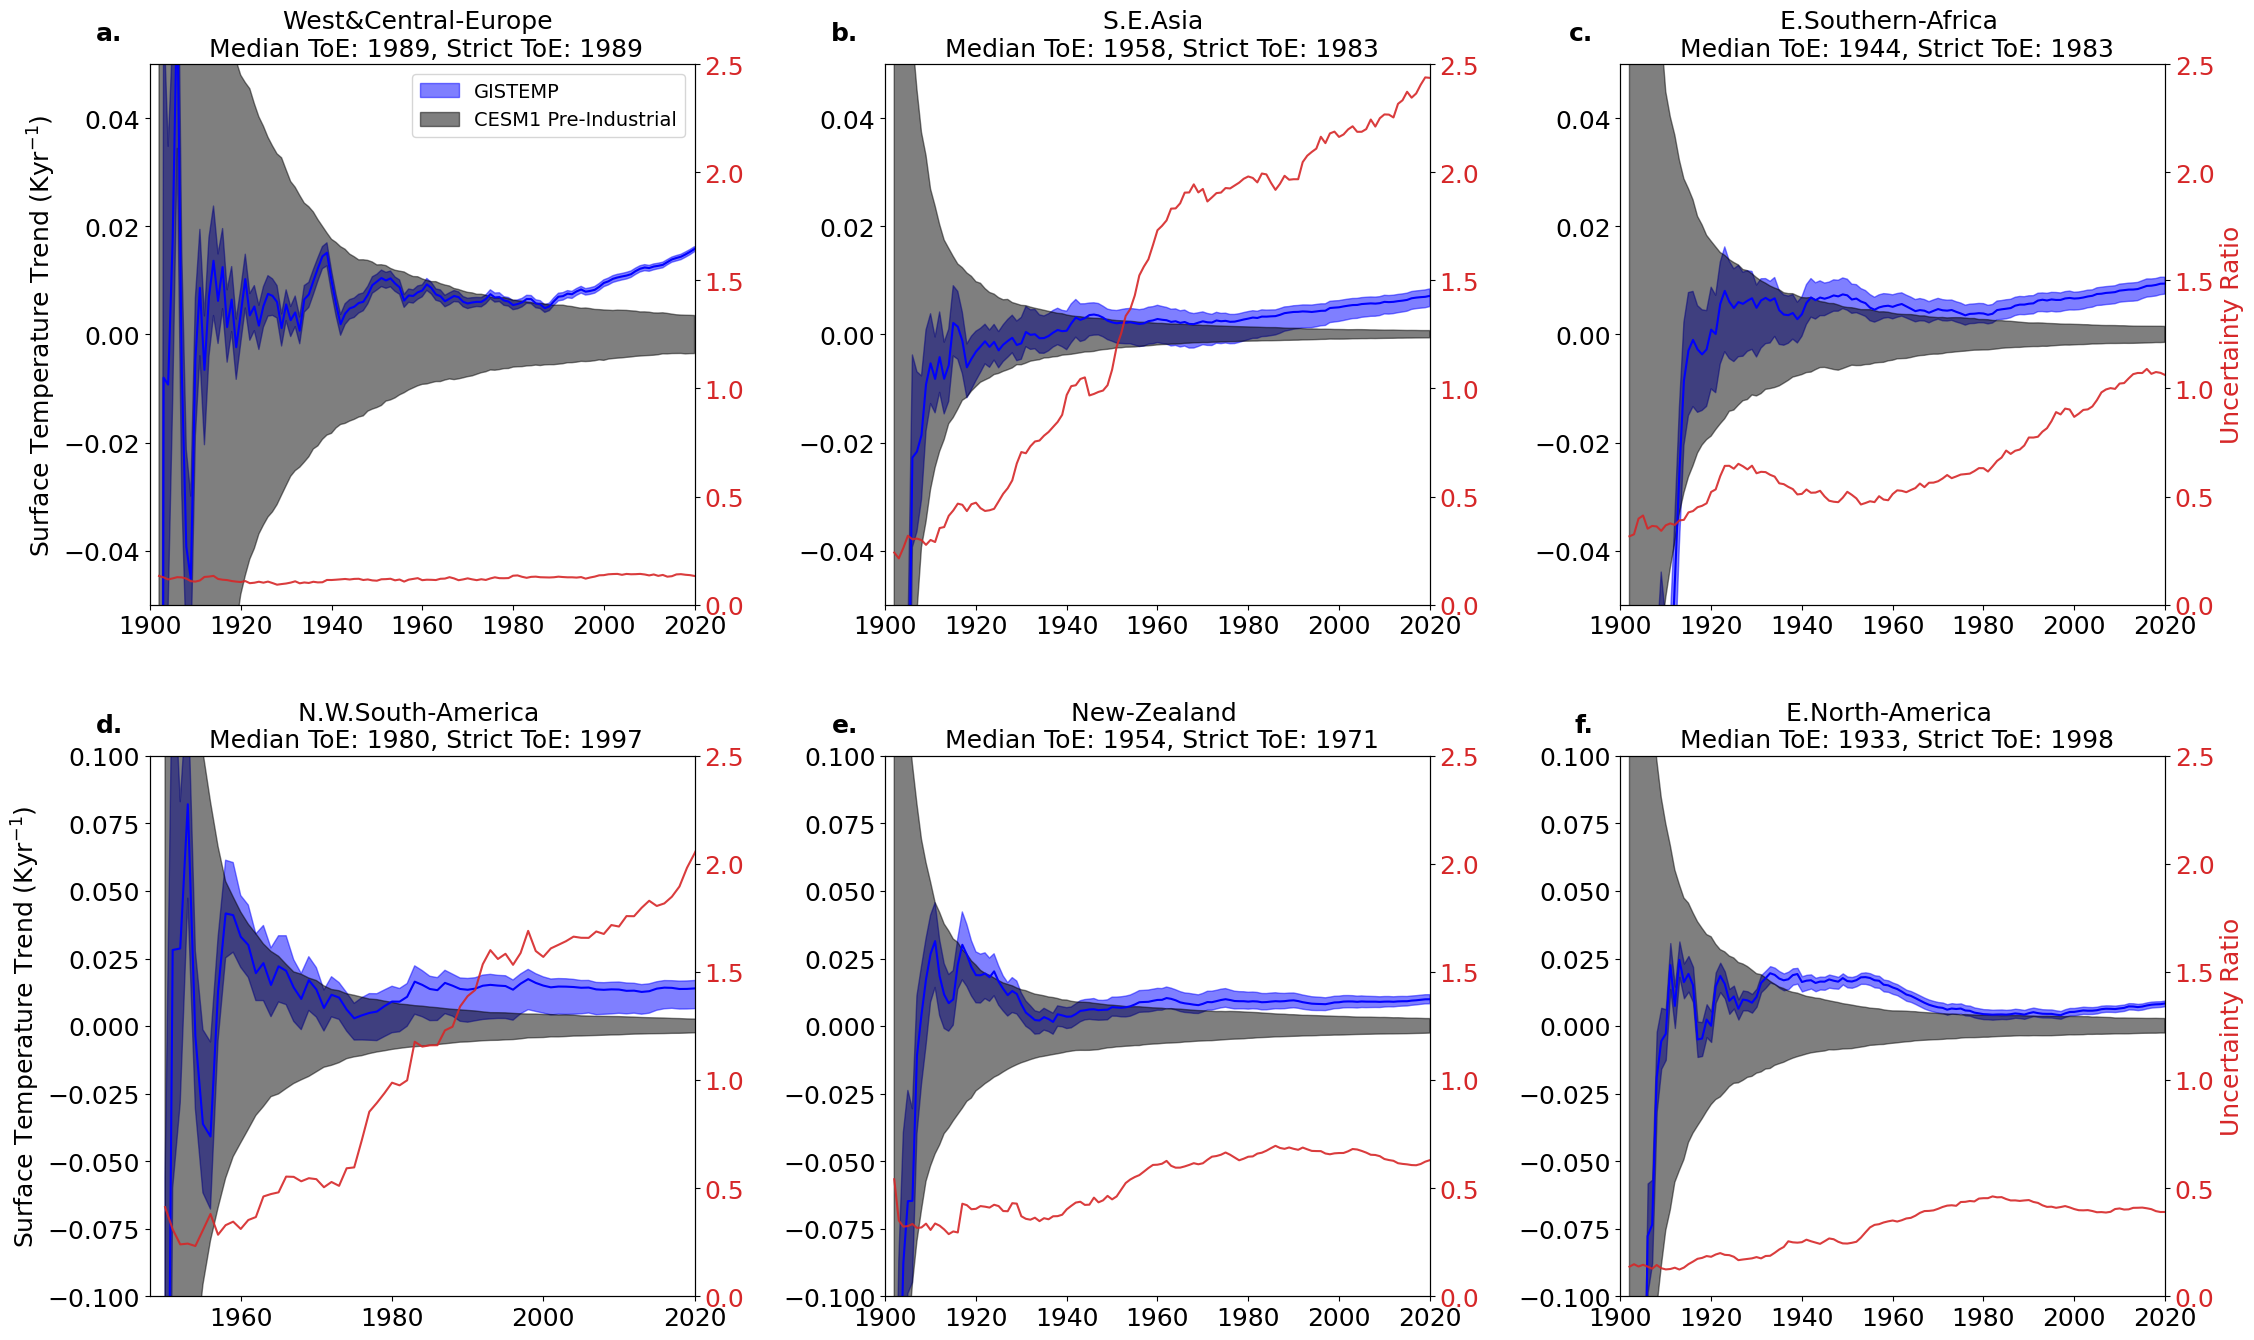

In [23]:
fig,axs = plt.subplots(2,3,figsize=(26,16))
axs = axs.flat

fig.subplots_adjust(hspace=0.28,wspace=0.35)

# Set values here:
# 5: SE North America
# 9: N.W. S. America
# 13: SW S. America
# 17: West&Central-Europe
# 42: S. Australia
# 43: New-Zealand
# 23: N. Eastern-Africa 
# 24: S.Eastern-Africa
# 26: E.Southern-Africa
# 33: E. Central Asia
# 34: Tibetan Plateau (small delay)
# 38: S.E. Asia
region_indices = [17, 38, 26, 9, 43, 5] # Adds New Zealand
region_ylims   = [[-0.05,0.05],[-0.05,0.05],[-0.05,0.05],[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],]

obs_percentile_data   = gistemp_regional_trendpercs_all
obs_startyear_data    = gistemp_regional_startyears
model_percentile_data = cesm1_pic_regional_trends_all

fontsize = 18

axs2 = []

for region_index,ylim,ax in zip(region_indices,region_ylims,axs):

    startyear = obs_startyear_data.sel(RegionIndex=region_index)
    year_gistemp = startyear + obs_percentile_data.duration - 1
    year_cesm1   = startyear + model_percentile_data.duration - 1

    # Compute the mean and strict ToEs
    _mean_tte        = mean_tte.sel(RegionIndex=region_index)
    _strict_tte      = strict_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    
    if (_strict_tte == 2020): _strict_tte = np.nan

    ax.fill_between(year_gistemp,
                    obs_percentile_data.sel(percentile=0.025,RegionIndex=region_index),
                    obs_percentile_data.sel(percentile=0.975,RegionIndex=region_index),
                    color='blue',
                    alpha=0.5,
                    label='GISTEMP',
                   )

    ax.fill_between(year_cesm1,
                    model_percentile_data.sel(percentile=0.025,RegionIndex=region_index),
                    model_percentile_data.sel(percentile=0.975,RegionIndex=region_index),
                    color='black',
                    alpha=0.5,
                    label='CESM1 Pre-Industrial',
                   )

    ax.plot(year_gistemp,
            obs_percentile_data.sel(percentile=0.50,RegionIndex=region_index),
            color='blue'
           )

    ax.tick_params(axis='both', labelsize=18)

    ax.set_xlim(startyear, 2020)
    ax.set_ylim(ylim)
    
    # Set up another y-axis on the right side of the plot
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.plot(
        startyear + gistemp_cesm1_uncratio.duration - 1,
        _gistemp_cesm1_uncratio,
        color=color,
        alpha=0.9,
    )
    ax2.set_ylim([0,2.5])
    ax2.tick_params(axis='y', labelcolor=color,labelsize=18)        

    title_p1 = str(obs_percentile_data.sel(RegionIndex=region_index).RegionName.values)

    if np.isnan(_strict_tte) and np.isnan(_mean_tte):
        title_p2 = 'Median ToE: None, Strict ToE: None'
    elif np.isnan(_strict_tte):
        title_p2 = 'Median ToE: %d, Strict ToE: None' % (_mean_tte)
    else:
        title_p2 = 'Median ToE: %d, Strict ToE: %d' % (_mean_tte, _strict_tte)

    ax.set_title('%s \n %s' % (title_p1,title_p2),fontsize=fontsize)
    
    axs2.append(ax2)

axs[0].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=fontsize)
axs[3].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=fontsize)

axs2[2].set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)
axs2[5].set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)

axs[0].legend(fontsize=fontsize-4)

# Add subplot labels
axs[0].text(-0.05, 1.08, 'a.', transform=axs[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[1].text(-0.05, 1.08, 'b.', transform=axs[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[2].text(-0.05, 1.08, 'c.', transform=axs[2].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[3].text(-0.05, 1.08, 'd.', transform=axs[3].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[4].text(-0.05, 1.08, 'e.', transform=axs[4].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[5].text(-0.05, 1.08, 'f.', transform=axs[5].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

In [24]:
to_png(
    file=fig,
    filename='ToEplots_IPCCregions',
    loc="../figures/",
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)